# Lab08 - LSTM Sentiment Analysis

## Introduction
In this lab, you will implement a Long Short-Term Memory (LSTM) Network using PyTorch to perform sentiment analysis on text data. By the end of this session, you will have built a complete pipeline that:

1. Preprocesses text data
2. Tokenizes text using subword tokenization
3. Builds an LSTM model
4. Trains the model
5. Evaluates its performance
6. Uses the model for predictions

### Outline
1. [Data Preparation](#Section-1:-Data-Preparation)
   1. [Download and Load the Dataset](#1.1-Download-and-Load-the-Dataset)
   2. [Data Preprocessing](#1.2-Data-Preprocessing)
   3. [Split the dataset](#1.3-Split-the-dataset)
2. [Subword Tokenization](#Section-2:-Subword-Tokenization)
   1. [Initialize the Tokenizer](#2.1-Initialize-the-Tokenizer)
   2. [Create the tokenization function](#2.2-Create-the-tokenization-function)
   3. [Create Dataset and DataLoader](#2.3-Create-Dataset-and-DataLoader)
3. [Building the LSTM Model](#Section-3:-Building-the-LSTM-Model)
   1. [Define the Model Architecture](#3.1-Define-the-Model-Architecture)
   2. [Initialize the Model](#3.2-Initialize-the-Model)
4. [Training the Model](#Section-4:-Training-the-Model)
   1. [Define loss function and optimizer](#4.1-Define-loss-function-and-optimizer)
   2. [Define the training and evaluation functions](#4.2-Define-the-training-and-evaluation-functions)
5. [Visualization and New Predictions](#Section-5:-Visualization-and-New-Predictions)
   1. [Visualize Training Progress](#5.1-Visualize-Training-Progress)
   2. [Making Predictions with New Text](#5.2-Making-Predictions-with-New-Text)
   
First, let's import the required libraries:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR

# import library
import kagglehub
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils import clip_grad_norm_
from transformers import AutoTokenizer

Set random seed for reproducibility

In [2]:
torch.manual_seed(42)
np.random.seed(42)

Check if GPU is available

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


---
# Section 1: Data Preparation

## 1.1 Download and Load the Dataset 

For this lab, we'll use the [IMDB movie review](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) dataset, which contains 50,000 movie reviews labeled as positive or negative.  Download a sample of the IMDB dataset from kagglehub.

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews") # this is a string type(path) = string

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [5]:
print(os.listdir(path))
df = pd.read_csv(os.path.join(path, 'IMDB Dataset.csv'))
print(df.shape)
print(df.columns.tolist())
# df.sample(15) # random sample
df.head(10)

['IMDB Dataset.csv']
(50000, 2)
['review', 'sentiment']


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


Let's explore the IMBD database. First, let's check if the classes are balanced.

In [6]:
sentiment_counts = df['sentiment'].value_counts()
print("\nClass distribution:")
print(sentiment_counts)


Class distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


Generate the `label` (`float32`) for the database where:
- `label = 1.` if `sentiment == 'positive'`
- `label = 0.` if `sentiment == 'negative'`.

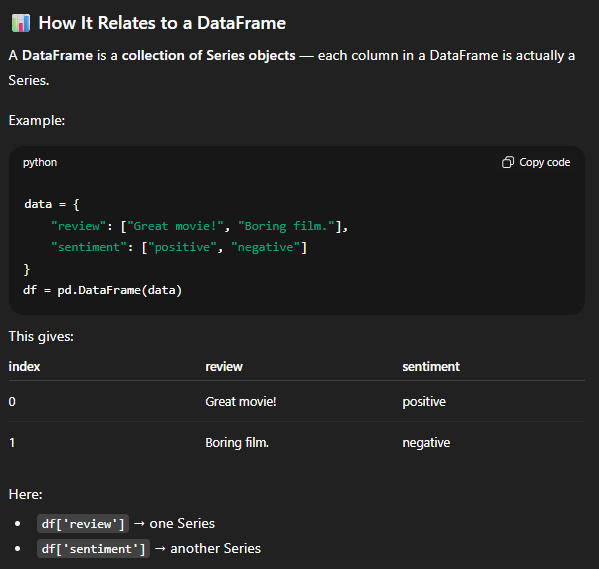
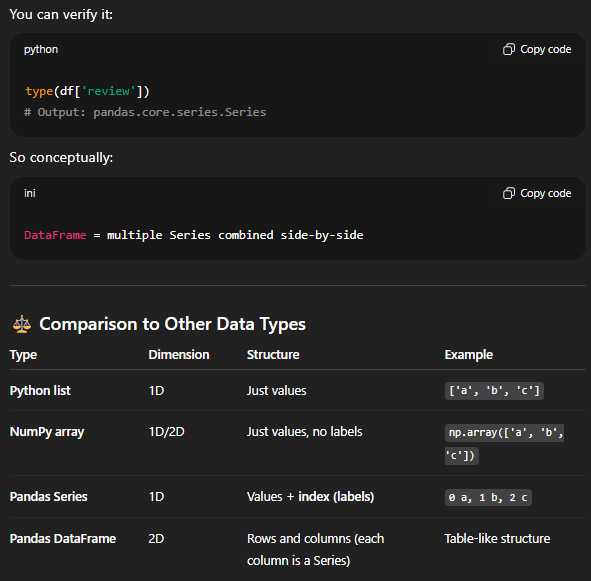
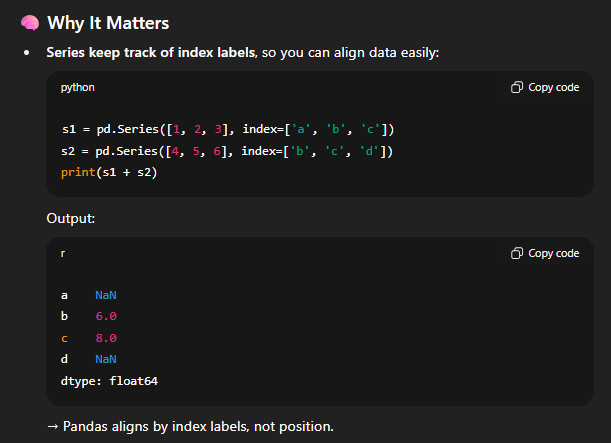

In [7]:
df.review

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 50000, dtype: object

In [8]:
result = df['sentiment'] == 'positive' # returns a boolean value. "True" if positive
result_int = (df['sentiment'] == 'positive').astype('float32')
print(result)
print(result_int)

0         True
1         True
2         True
3        False
4         True
         ...  
49995     True
49996    False
49997    False
49998    False
49999    False
Name: sentiment, Length: 50000, dtype: bool
0        1.0
1        1.0
2        1.0
3        0.0
4        1.0
        ... 
49995    1.0
49996    0.0
49997    0.0
49998    0.0
49999    0.0
Name: sentiment, Length: 50000, dtype: float32


In [9]:
df['label'] = (df['sentiment'] == 'positive').astype('float32')

df.label.head(10)

for i in range(10):
    if df.iloc[i]['label'] == 1.0:
        print("Correct")
    else:
        print("Wrong")

Correct
Correct
Correct
Wrong
Correct
Correct
Correct
Wrong
Wrong
Correct


In [10]:
print(df.sentiment.head(2).tolist())
print(df.sentiment.head(2).values)

['positive', 'positive']
['positive' 'positive']


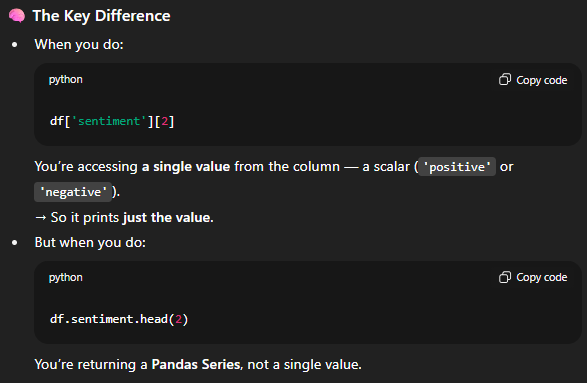
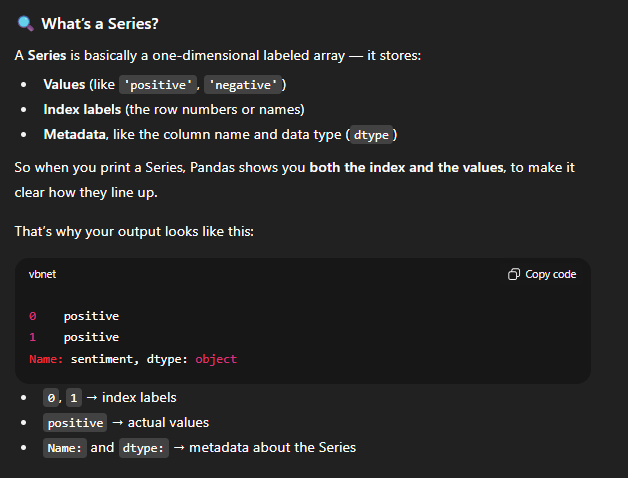

In [11]:
print(df['sentiment'][2]) # access using value index
print(df.sentiment.head(2))

positive
0    positive
1    positive
Name: sentiment, dtype: object


## 1.2 Data Preprocessing

Let's create a function to clean the `text` input
* Convert the text to string in case there is any non-string input: [str(text)](https://www.w3schools.com/python/ref_func_str.asp)
* Convert text to lower case: [text.lower()](https://www.w3schools.com/python/ref_string_lower.asp)
* Remove html tags by using regular expression: [re.sub(r'<.*?>', '', text)](https://docs.python.org/3/library/re.html#re.sub)
* Replace multiple spaces with a single space: [re.sub(r'\s+', ' ', text)](https://docs.python.org/3/library/re.html#re.sub)
* Remove leading / trailing whitespace: [text.strip()](https://www.w3schools.com/python/ref_string_strip.asp)

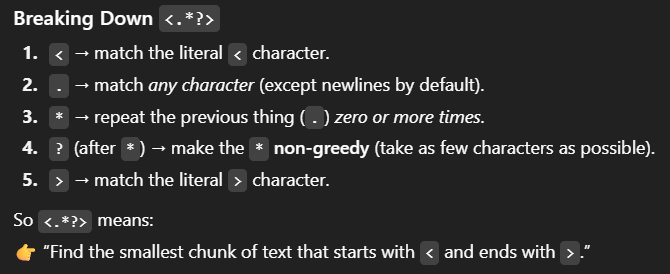

In [12]:
def clean_text(text):
    # Convert to string (in case of any non-string input)
    text = str(text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    
    # Remove leading/trailing whitespace
    text = text.strip()
    
    return text

In [13]:
text = "<br>   TEST my code     in    .. python  <br>"
clean_text(text)

'test my code in .. python'

Now, clean the `review` column by applying ([pandas.DataFrame.apply](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html)) the `clean_dataset` method. Save the cleaned review as `cleaned_review`.

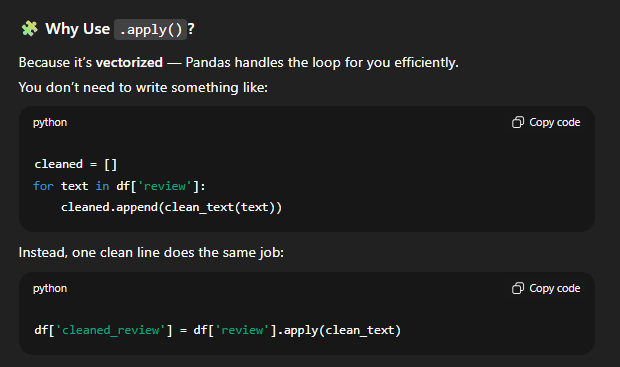

In [14]:
# testing apply function from pandas, just throw in the text preprocessing function in, it will apply it in all the rows
df['review'].apply(clean_text)

0        one of the other reviewers has mentioned that ...
1        a wonderful little production. the filming tec...
2        i thought this was a wonderful way to spend ti...
3        basically there's a family where a little boy ...
4        petter mattei's "love in the time of money" is...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot, bad dialogue, bad acting, idiotic di...
49997    i am a catholic taught in parochial elementary...
49998    i'm going to have to disagree with the previou...
49999    no one expects the star trek movies to be high...
Name: review, Length: 50000, dtype: object

In [15]:
# Clean the review
df['cleaned_review'] = df['review'].apply(clean_text)

# Display a sample of cleaned reviews
print("\nSample of cleaned reviews:")
for i in range(3):
    print(f"Original : {df['review'].iloc[i][:100]}...")
    print(f"Cleaned  : {df['cleaned_review'].iloc[i][:100]}...")
    print()


Sample of cleaned reviews:
Original : One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. The...
Cleaned  : one of the other reviewers has mentioned that after watching just 1 oz episode you'll be hooked. the...

Original : A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-B...
Cleaned  : a wonderful little production. the filming technique is very unassuming- very old-time-bbc fashion a...

Original : I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air con...
Cleaned  : i thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air con...



## 1.3 Split the dataset

Use [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the data set two:  80% for training and 20% for testing

In [16]:
len(df)

50000

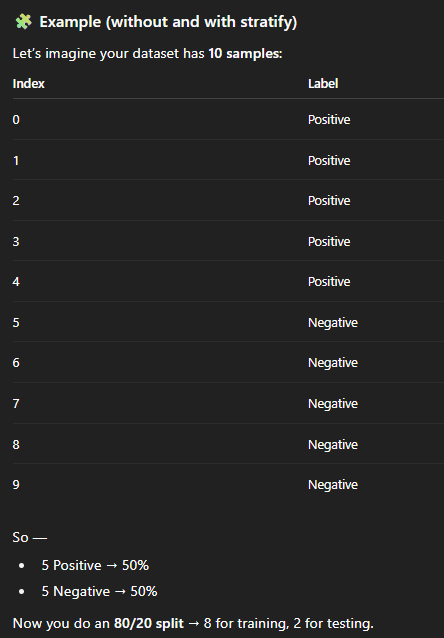
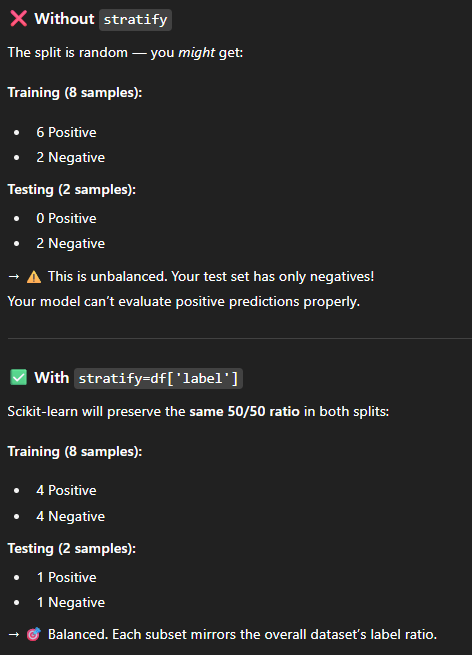
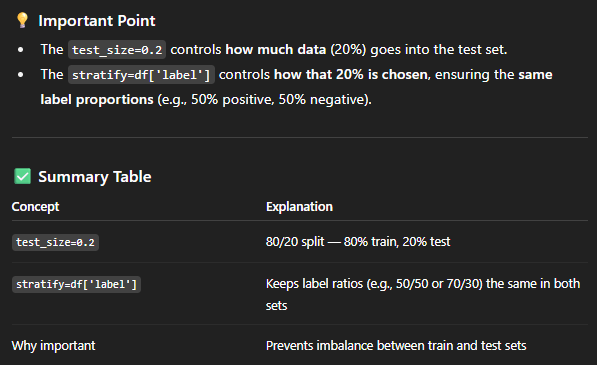

In [17]:
# Split into train and test sets
# stratify is to balance the training and testing data, (positive/negative) sentiment
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(f"Training set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")

Training set size: 40000
Testing set size: 10000


In [18]:
df

,review,sentiment,label,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,1.0,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,1.0,a wonderful little production. the filming tec...
2,I thought this was a wonderful way to spend ti...,positive,1.0,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,0.0,basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1.0,"petter mattei's ""love in the time of money"" is..."
...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,1.0,i thought this movie did a down right good job...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0.0,"bad plot, bad dialogue, bad acting, idiotic di..."
49997,I am a Catholic taught in parochial elementary...,negative,0.0,i am a catholic taught in parochial elementary...
49998,I'm going to have to disagree with the previou...,negative,0.0,i'm going to have to disagree with the previou...


---
# Section 2: Subword Tokenization

Instead of using traditional word tokenization, we will use the GPT2 tokenizerm, a modern subword tokenizer which can handle out-of-vocabulary words better and captures the morphology of the language.

## 2.1 Initialize the Tokenizer

1. Create the tokenizer use HuggingFace's [transformers.AutoTokenizer](https://huggingface.co/docs/transformers/v4.51.3/en/model_doc/auto#transformers.AutoTokenizer) to load the `GPT2` tokenizer.
2. Set the padding token to `eos_token`. This is because GPT-2 was originally trained without any padding since it was trained on continuous chunks of text. 

In [19]:
BATCH_SIZE = 32
MAX_SEQ_LEN = 200

In [20]:
# len(tokenizer.vocab)

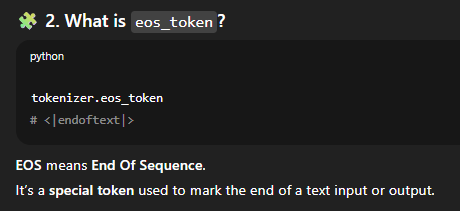
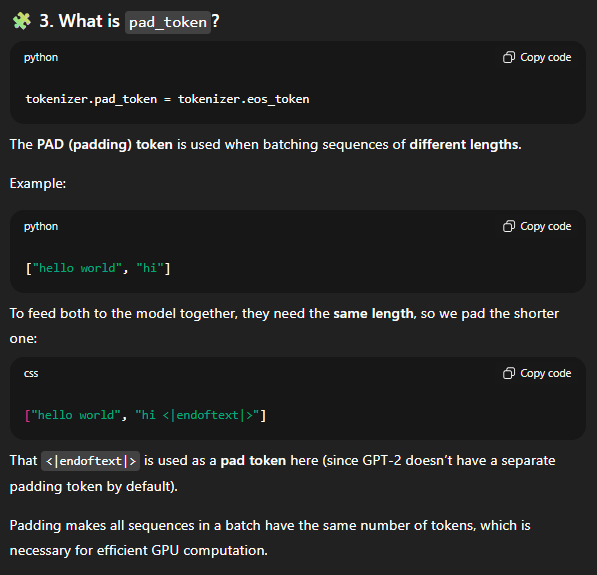

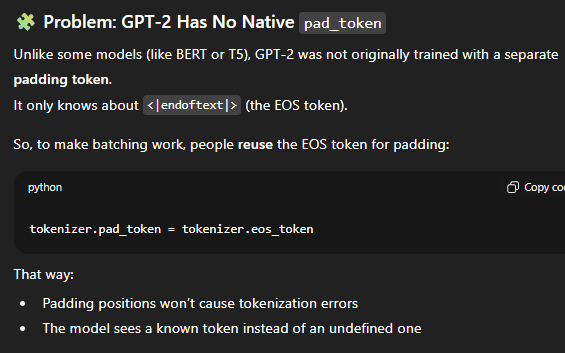

In [21]:
from transformers import AutoTokenizer

# Use GPT-2's tokenizer (similar to tiktoken)
tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

print(f"Vocabulary size: {len(tokenizer)}")
print(f'{tokenizer.pad_token = }')

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Vocabulary size: 50257
tokenizer.pad_token = '<|endoftext|>'


We can use the tokenizer to tokenize ([tokenizer.tokenize()](https://huggingface.co/docs/transformers/v4.51.0/en/main_classes/tokenizer#transformers.PreTrainedTokenizer.tokenize)) a sample text into a list of strings.

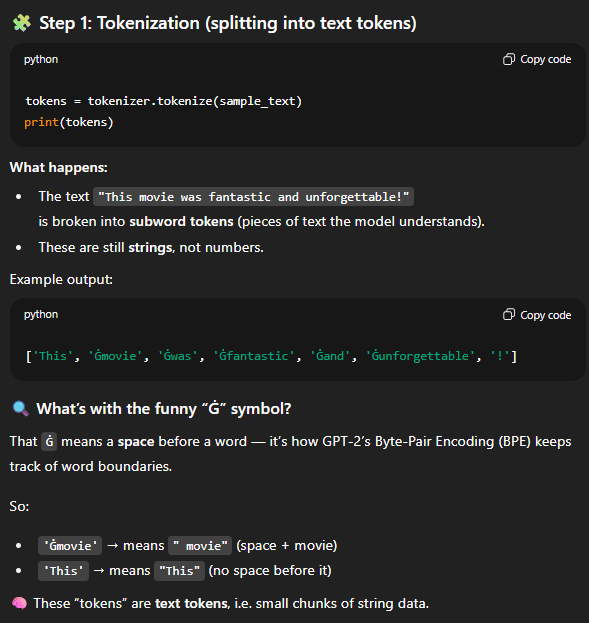

In [22]:
sample_text = "This movie was fantastic and unforgettable!"

tokens = tokenizer.tokenize(sample_text)
print(tokens)

['This', 'Ġmovie', 'Ġwas', 'Ġfantastic', 'Ġand', 'Ġunforgettable', '!']


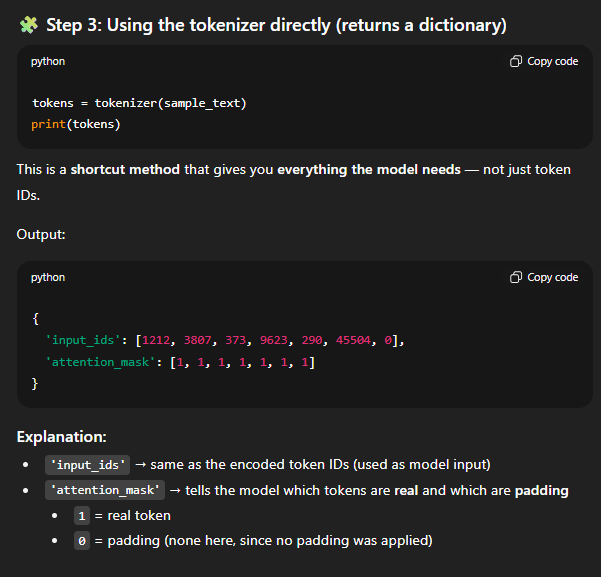

In [23]:
tokens = tokenizer(sample_text)
print(tokens)

{'input_ids': [1212, 3807, 373, 9623, 290, 45504, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}


We can use the tokenizer to tokenize and encode ([tokenizer.encode()](https://huggingface.co/docs/transformers/v4.51.0/en/main_classes/tokenizer#transformers.PreTrainedTokenizer.encode) a sample text into a list of integers.


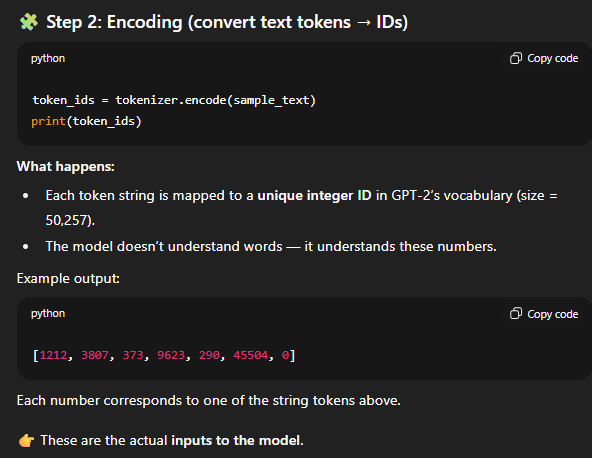

In [24]:
token_ids = tokenizer.encode(sample_text) # string --> list of string tokens --> list of integers (ids)
token_ids

[1212, 3807, 373, 9623, 290, 45504, 0]

When calling the tokenizer ([tokenizer()](https://huggingface.co/docs/transformers/en/main_classes/tokenizer#transformers.PreTrainedTokenizer.__call__)), it will return not only the `token_ids` but also the `attention_masks`. The `attention_mask` is used to indicate which tokens should be attended to (1) and which are padding (0), helping the model ignore padding during processing.

In [25]:
encoding = tokenizer(sample_text)
print(encoding)
print("Input ids: ",encoding['input_ids'])
print("Attention Mask: ",encoding['attention_mask'])

{'input_ids': [1212, 3807, 373, 9623, 290, 45504, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}
Input ids:  [1212, 3807, 373, 9623, 290, 45504, 0]
Attention Mask:  [1, 1, 1, 1, 1, 1, 1]


We can also clip the maximum number of tokens by setting the `max_length` argument.

You can also use the [tokenizer](https://huggingface.co/docs/transformers/en/main_classes/tokenizer#transformers.PreTrainedTokenizer.__call__)  to pad it to the maximum length (`padding="max_length"`). Note that the `attention_mask` for tokens belonging to the original text will be set to 1 while all padding tokens will be set to 0.

In [26]:
sample_text = "This movie was fantastic and unforgettable!"

encoding = tokenizer(sample_text, truncation=True, max_length=5)
print(encoding)
print("Input ids: ",encoding['input_ids'])
print("Attention Mask: ",encoding['attention_mask'])

{'input_ids': [1212, 3807, 373, 9623, 290], 'attention_mask': [1, 1, 1, 1, 1]}
Input ids:  [1212, 3807, 373, 9623, 290]
Attention Mask:  [1, 1, 1, 1, 1]


In [27]:
encoding = tokenizer(sample_text, truncation=True, padding='max_length', max_length=15) # add truncation = True to remove the error
print(encoding)
print("Input ids: ",encoding['input_ids'])
print("Attention Mask: ",encoding['attention_mask'])

{'input_ids': [1212, 3807, 373, 9623, 290, 45504, 0, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]}
Input ids:  [1212, 3807, 373, 9623, 290, 45504, 0, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]
Attention Mask:  [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


## 2.2 Create the tokenization function

To simplify the tokenization process, we shall create a function to tokenize and encode the text. The input will be truncated if it is longer than `MAX_SEQ_LEN`. The output is automatically converted to tensor (`return_tensors='pt'`)

In [28]:
def tokenize_and_encode(text, max_length=MAX_SEQ_LEN):
    """
    Tokenize and encode a text using our subword tokenizer.
    Returns token IDs and attention mask.
    """
    # Tokenize and truncate/pad to max_length
    encoding = tokenizer(
        text,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt' # Returns PyTorch tensors (instead of Python lists) — ready for model input
    )

    # need squeeze because the return output is in tensor shape, which comes with an extra dimension
    return encoding['input_ids'].squeeze(), encoding['attention_mask'].squeeze()

In [29]:
sample_ids, sample_mask = tokenize_and_encode("This is a test of our tokenizer.", max_length=20)
print(f"Token IDs: {sample_ids}")
print(f"Attention Mask: {sample_mask}")

Token IDs: tensor([ 1212,   318,   257,  1332,   286,   674, 11241,  7509,    13, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


## 2.3 Create Dataset and DataLoader

Now, let's create our dataset. 

In [30]:
df

,review,sentiment,label,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,1.0,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,1.0,a wonderful little production. the filming tec...
2,I thought this was a wonderful way to spend ti...,positive,1.0,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,0.0,basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1.0,"petter mattei's ""love in the time of money"" is..."
...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,1.0,i thought this movie did a down right good job...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0.0,"bad plot, bad dialogue, bad acting, idiotic di..."
49997,I am a Catholic taught in parochial elementary...,negative,0.0,i am a catholic taught in parochial elementary...
49998,I'm going to have to disagree with the previou...,negative,0.0,i'm going to have to disagree with the previou...


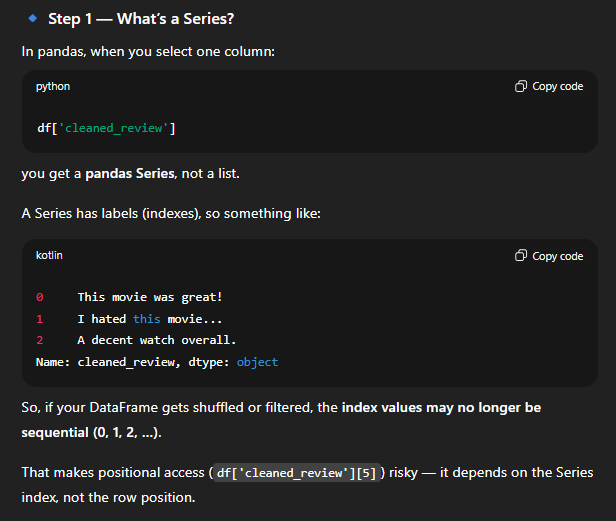
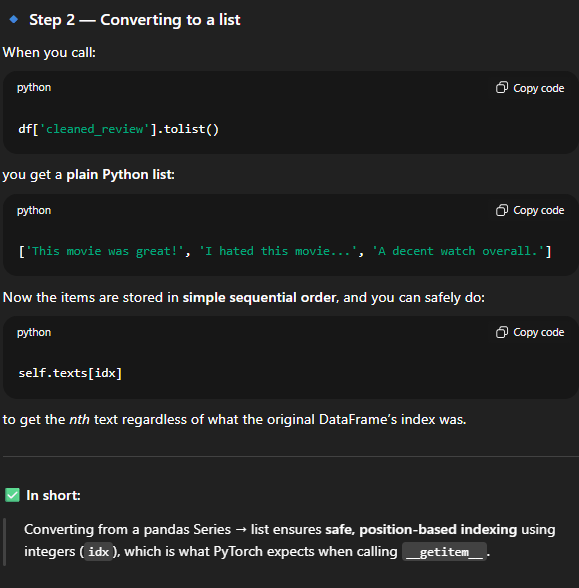

In [31]:
class IMDBDataset(Dataset):
    def __init__(self, df):
        # get the texts (movie reviews) as a list of strings
        self.texts = df['cleaned_review'].tolist() # get 'cleaned_review', convert from series to list for positinal indexing

        # get the labels (sentiment). The label is a 1-D float tensor
        self.labels = torch.tensor(df['label'].tolist())  # get 'label', convert from series to list to tensor
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # get the text and call 'tokenize_and_encode' to get the input_ids and attention_mask
        input_ids, attention_mask = tokenize_and_encode(self.texts[idx])
        label = self.labels[idx]
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'label': label
        }

Create the dataset.

In [32]:
train_dataset = IMDBDataset(train_df)
test_dataset = IMDBDataset(test_df)

In [33]:
df.iloc[1]['cleaned_review'][:200]

'a wonderful little production. the filming technique is very unassuming- very old-time-bbc fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. the actors'

In [34]:
train_dataset.__len__()

40000

In [35]:
train_dataset.__getitem__(0)

{'input_ids': tensor([   72,  4978,   428,  1310, 16840,  6635,   416,  5778,   736,   287,
          7169,   393,   705,  6659,    13,  1312,   373,   379,   257, 26624,
         21421,   284,   766,   734,  1468, 14397, 20681,    12, 12463,  6918,
            13,   262, 21421,   373, 11856,  1336,   290,   357,  4480,   645,
          6509,     8,   484,  3751,   257,  7684,   286, 20681,    12, 12463,
          1790, 42078,    82,   357,  1462,   651,   514,   287,   262, 10038,
           737,   749,   547,  6454, 28297,   475,   428,  1625,   319,   290,
            11,  1626,  4201,    11,   262,  5386,   373,   287, 24258,   873,
             0,   262,  4094,  6487,  1625,   618,   484,  3751,   366,  1050,
           259,   919,  8591,   544,     1,  1719,  3236, 29181,   275, 13271,
          2427,   286,  4190,   319,   607,  1182,    13,   673,  3073,   379,
           262,  4676,    11,  3607,   257, 18288,  8212,   290, 34833,    13,
           326,   925,   340,   772, 36

In [36]:
# I think this is not correct
result = train_dataset[0]
print("Input ids:", result['input_ids'])
print("Attention mask: ", result['attention_mask'])
print("Label: ", result['label'])

Input ids: tensor([   72,  4978,   428,  1310, 16840,  6635,   416,  5778,   736,   287,
         7169,   393,   705,  6659,    13,  1312,   373,   379,   257, 26624,
        21421,   284,   766,   734,  1468, 14397, 20681,    12, 12463,  6918,
           13,   262, 21421,   373, 11856,  1336,   290,   357,  4480,   645,
         6509,     8,   484,  3751,   257,  7684,   286, 20681,    12, 12463,
         1790, 42078,    82,   357,  1462,   651,   514,   287,   262, 10038,
          737,   749,   547,  6454, 28297,   475,   428,  1625,   319,   290,
           11,  1626,  4201,    11,   262,  5386,   373,   287, 24258,   873,
            0,   262,  4094,  6487,  1625,   618,   484,  3751,   366,  1050,
          259,   919,  8591,   544,     1,  1719,  3236, 29181,   275, 13271,
         2427,   286,  4190,   319,   607,  1182,    13,   673,  3073,   379,
          262,  4676,    11,  3607,   257, 18288,  8212,   290, 34833,    13,
          326,   925,   340,   772, 36090,   959,    

Before transforming to list and tensors

In [37]:
train_dataset.texts # already in list

['i caught this little gem totally by accident back in 1980 or \'81. i was at a revival theatre to see two old silly sci-fi movies. the theatre was packed full and (with no warning) they showed a bunch of sci-fi short spoofs (to get us in the mood). most were somewhat amusing but this came on and, within seconds, the audience was in hysterics! the biggest laugh came when they showed "princess laia" having huge cinnamon buns instead of hair on her head. she looks at the camera, gives a grim smile and nods. that made it even funnier! you gotta see "chewabacca" played by what looks like a muppet! it was extremely silly and stupid...but i couldn\'t stop laughing. most of the dialogue was drowned out because of all the laughter. also if you know "star wars" pretty well it\'s even funnier--they deliberately poke fun at some of the dialogue. this really works with an audience! a definite 10!',
 'i can\'t believe that i let myself into this movie to accomplish a favor my friends ask me early t

After converting to list and tensors

In [38]:
print("First 3 samples:")
for i in range(3):
    print("Label:", train_dataset.labels[i], "| Text:", train_dataset.texts[i][:200], "...")

First 3 samples:
Label: tensor(1.) | Text: i caught this little gem totally by accident back in 1980 or '81. i was at a revival theatre to see two old silly sci-fi movies. the theatre was packed full and (with no warning) they showed a bunch o ...
Label: tensor(0.) | Text: i can't believe that i let myself into this movie to accomplish a favor my friends ask me early this april 14, 2007. this movie certainly a pain in your ass in theater and sickly boring, i haven't eve ...
Label: tensor(0.) | Text: *spoiler alert!* it just gets to me the nerve some people have to remake (and i use the term loosely here..) good movies. in the american version of this dutch thriller, someone decided the original e ...


Create the dataloader.

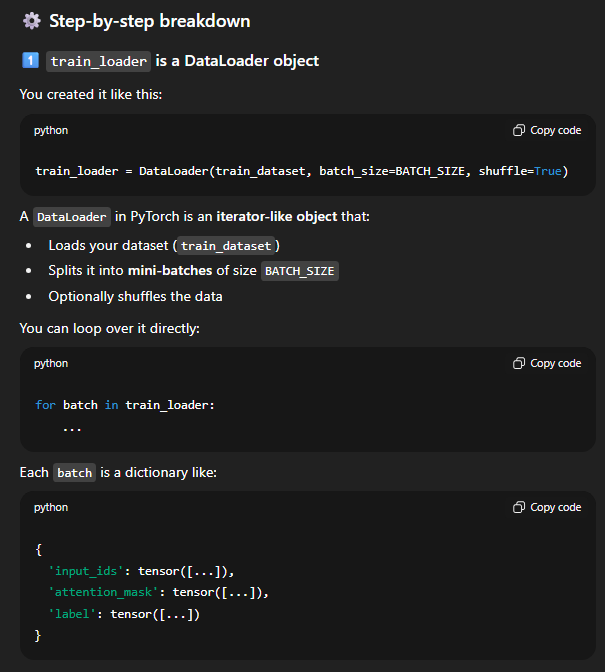


In [39]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

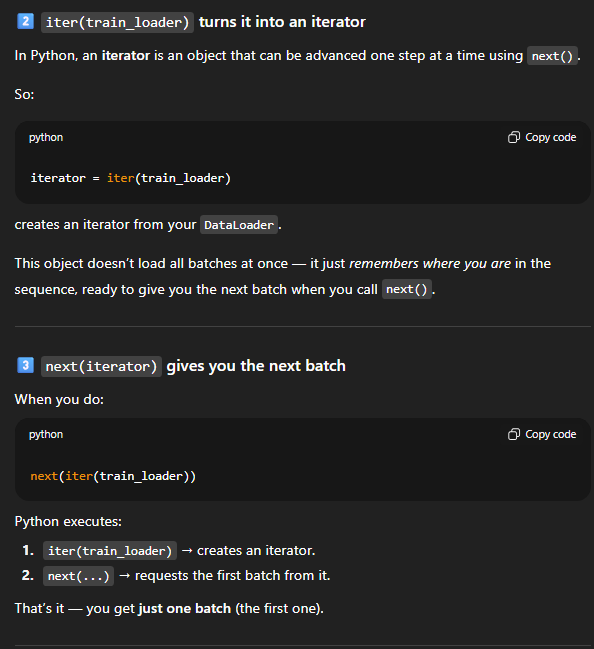
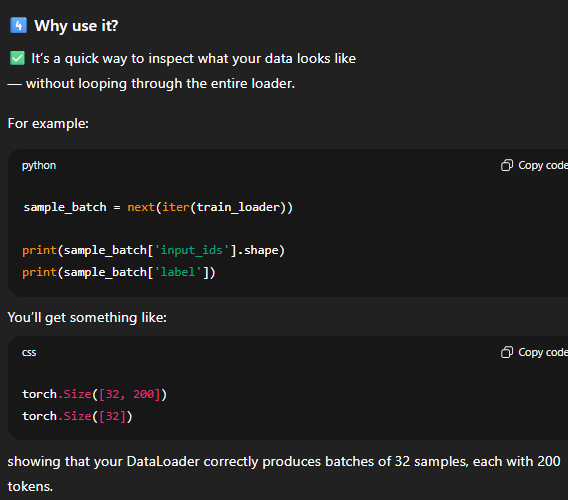

In [40]:
sample_batch = next(iter(train_loader))

print(f"Batch shape of input_ids      : {sample_batch['input_ids'].shape}")
print(f"Batch shape of attention_mask : {sample_batch['attention_mask'].shape}")
print(f"Batch shape of labels         : {sample_batch['label'].shape}")

Batch shape of input_ids      : torch.Size([32, 200])
Batch shape of attention_mask : torch.Size([32, 200])
Batch shape of labels         : torch.Size([32])


# nn.Embedding 

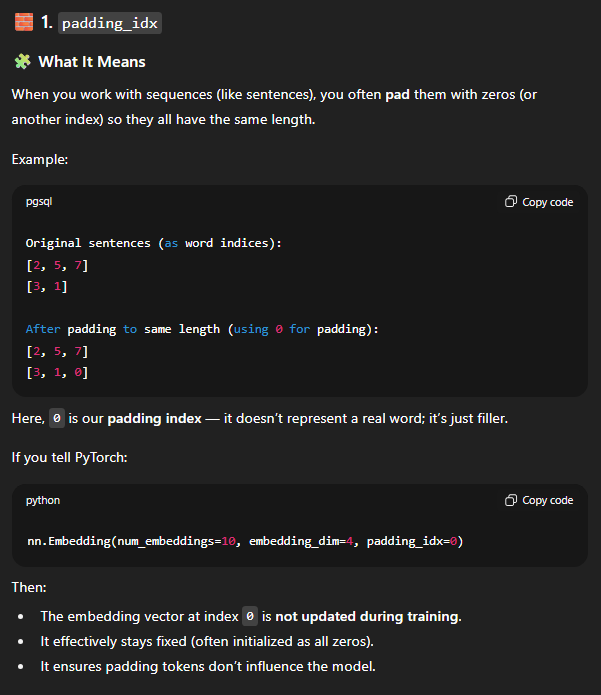
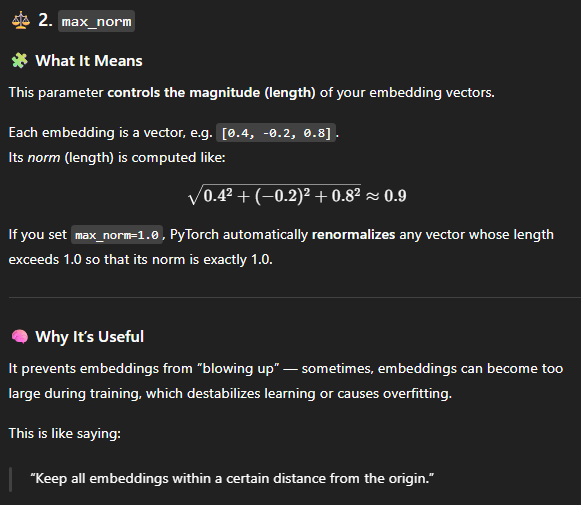

---
# Section 3: Building the LSTM Model

Now let's create our LSTM model for sentiment analysis, which will use the subword embeddings.

## 3.1 Define the Model Architecture

Implement the following model to perform sentiment classification on the IMDB dataset.

|No| **Layer / Operation**               | **Description**                                                                                   | **Configuration**                                         | **Input Shape**                        | **Output Shape**                        |
|---|------------------------------------|---------------------------------------------------------------------------------------------------|-----------------------------------------------------------|----------------------------------------|-----------------------------------------|
|1.| **Embedding** <br> ([nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)) | Converts token indices to dense vectors. Ignores padding index.                                  | `num_embeddings=VOCAB_SIZE`<br>`embedding_dim=EMBEDDING_DIM`<br>`padding_idx=PADDING_IX`     | `(batch_size, seq_len)`               | `(batch_size, seq_len, embedding_dim)`  |
|2.| **Pack Padded Sequence**  <br> ([torch.nn.utils.rnn.pack_padded_sequence](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html))         | Skips padded tokens during LSTM computation.                                                     | `enforce_sorted=False`                                    | `(batch_size, seq_len, embedding_dim)`| Packed sequence                         |
|3.| **LSTM** <br>([nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html))                        | Bidirectional LSTM layer that captures sequence context.                                         | `input_size=EMBEDDING_DIM`<br>`hidden_size=HIDDEN_SIZE`<br>`num_layers=NUM_LAYERS`<br>`bidirectional=True`<br>`batch_first=True` | Packed sequence                        | `hidden_state`: `(n_layers*2, batch_size, hidden_size)` |
|4.| **Concat Final Hidden States**  <br>([torch.cat](https://pytorch.org/docs/stable/generated/torch.cat.html))   | Concatenates last forward and backward hidden states.                                            | `hidden_state[-2,:,:]`<br>(forward direction, last layer and H)<br><br>`hidden_state[-1,:,:]`<br>(backward direction, last layer and H)                                   | `hidden_state`                         | `(batch_size, hidden_size*2)`            |
|5.| **Fully Connected (Linear)** <br>([nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)) | Projects LSTM output to target output dimension.                                                 | `in_features=HIDDEN_SIZE*2`<br>`out_features=OUTPUT_SIZE`                              | `(batch_size, hidden_size*2)`          | `(batch_size, output_size)`              |
|6.| **Output**                         | Final output of the model (e.g., logits).                                                        | —                                                         | `(batch_size, output_size)`            | `(batch_size, output_size)`              |

### Padded vs Packed sequences

The issue with using the original *padded input sequence* is that the model:
1. Processes padding tokens, wasting computation.
2. Includes padding in gradient updates, which can degrade learning.
3. Ignores actual sequence lengths, leading to inaccurate outputs and hidden states.
   
*Packing* avoids this problem by letting RNNs or LSTM process only the valid time steps. To do this, we pack a padded sequence into a *packed sequence*. The packed sequence is a compressed representation that removes padding so that it can be efficiently processed by RNNs or LSTMs. It is represented as a [PackedSequence](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.PackedSequence.html#torch.nn.utils.rnn.PackedSequence) which contains two things:
* `.data`: A tensor of shape `(length of concatenated original sequences, embedding_dim)` - all valid (unpadded) time steps concatenated
* `.batch_sizes`: A tensor of shape `(max_seq_len)` showing how many sequences have data at each time step.

To pack a padded sequence, use the command [torch.nn.utils.rnn.pack_padded_sequence](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html). Conversely, to unpack a packed sequence, use the command [torch.nn.utils.rnn.pad_packed_sequence](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_packed_sequence.html).

**Explains why attention_mask is needed as lenghts**

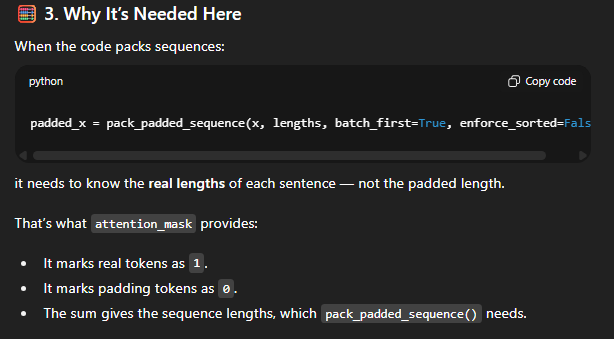

*Why sum attention mask across dim 1*

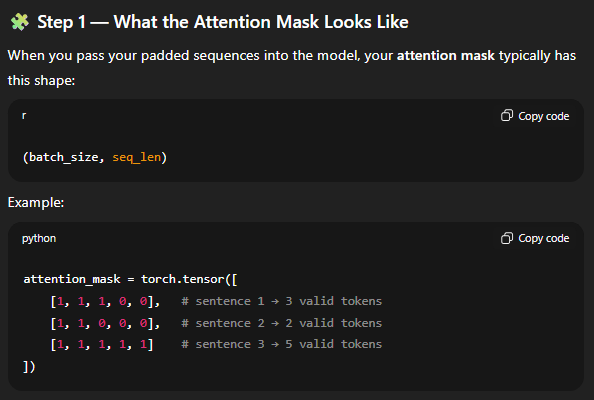
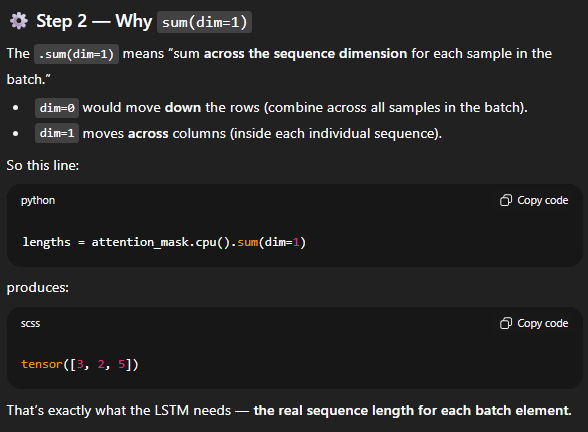
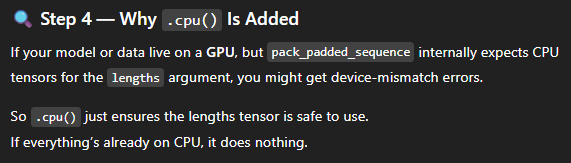

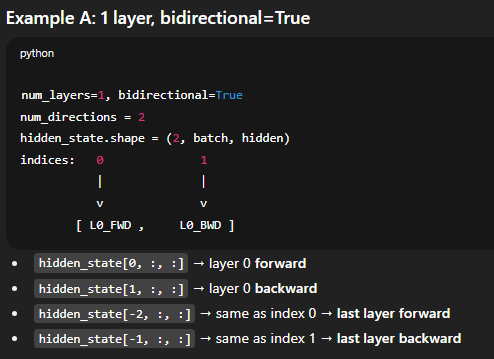
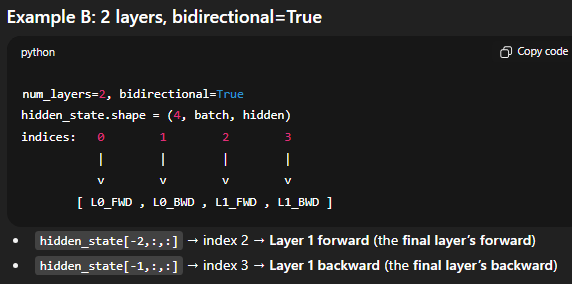
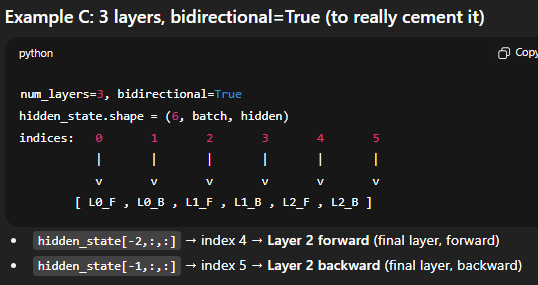

In [41]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size, num_layers, padding_idx):
        super().__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding(num_embeddings = vocab_size, embedding_dim = embedding_dim,
                                      padding_idx = padding_idx)
        
        # LSTM layer 
        self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_size, num_layers = num_layers, bidirectional = True,
                           batch_first = True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size * 2, output_size) # hidden_size * 2 becuase its bidirectional
                
    def forward(self, text, attention_mask=None):

        # Embed the text
        x = self.embedding(text)
        
        # get the original length of each sample
        lengths = attention_mask.cpu().sum(dim=1)

        # packed the input x
        padded_x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)

        # lstm output
        packed_out, (hidden_state, cell_state) = self.lstm(x)
            
        # concatenate the final forward and backward hidden states. Notes: Shape of hidden shape: [n layers * n directions, batch size, hidden dim]
        # [-2,:,:] takes the second last pass of layer 0
        # In theory, with 1 layer, the forward pass is the first item and the backward pass is the second item
        # If its -2, means getting the second last item which is the backward pass
        x = torch.cat((hidden_state[-2, :, :], hidden_state[-1, :, :]), dim=1)

        # Pass through linear layer
        x = self.fc(x)
        
        return x

## 3.2 Initialize the Model

Configure the network

In [42]:
EMBEDDING_DIM = 100                   # Size of embeddings
HIDDEN_SIZE = 128                     # Size of hidden dim
OUTPUT_SIZE = 1                       # Binary classification
NUM_LAYERS = 2                        # Number of LSTM layers

In [43]:
device = "cuda" if torch.cuda.is_available() else "cpu"
sample_batch = next(iter(train_loader))

input_ids = sample_batch['input_ids'].to(device)
attention_mask = sample_batch['attention_mask'].to(device)

Test the model

In [44]:
model = SentimentLSTM(vocab_size    = tokenizer.vocab_size,
                      embedding_dim = EMBEDDING_DIM,
                      hidden_size   = HIDDEN_SIZE,
                      output_size   = OUTPUT_SIZE,
                      num_layers    = NUM_LAYERS,
                      padding_idx   = tokenizer.pad_token_id)
model = model.to(device)
print(model)

SentimentLSTM(
  (embedding): Embedding(50257, 100, padding_idx=50256)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


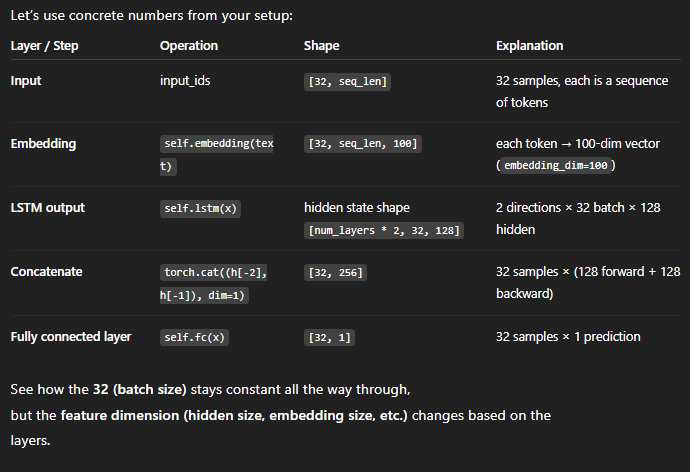

In [45]:
sample_batch = next(iter(train_loader))
input_ids = sample_batch['input_ids'].to(device)
attention_mask = sample_batch['attention_mask'].to(device)

out = model(input_ids, attention_mask) # same as calling model.forward(input_ids, attention_mask)
print(f'{out.shape = }')

out.shape = torch.Size([32, 1])


---
# Section 4: Training the Model

## 4.1 Define loss function and optimizer

Typically, 

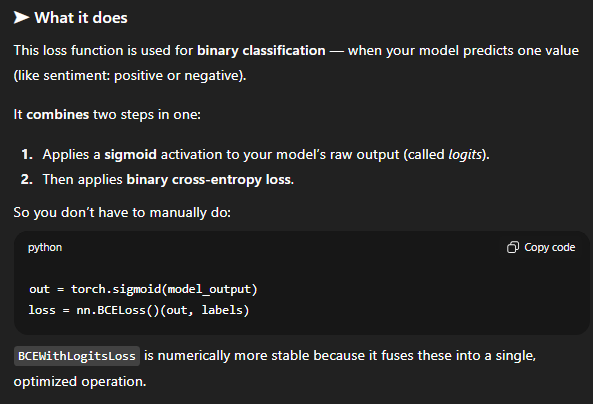
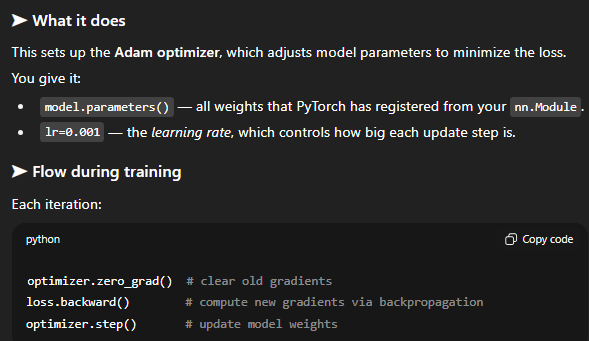

In [46]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Set up a learning rate scheduler.

In [47]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', # mode (str) – One of min, max. In min mode, lr will be reduced when the quantity monitored has stopped decreasing; in max mode it will be reduced when the quantity monitored has stopped increasing.
    factor=0.5, 
    patience=1, 
    verbose=True
)

## 4.2 Define the training and evaluation functions

In [48]:
N_EPOCHS = 5

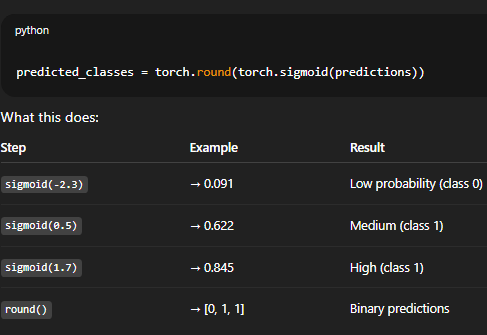

In [49]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    epoch_loss = 0.
    epoch_acc = 0.
    iter_loss = 0.
    iter_count = 0
    iter_trainacc = 0.
    
    model.train()
    
    for batch_idx, batch_data in enumerate(dataloader):
        # Move data to device
        input_ids = batch_data['input_ids'].to(device)
        attention_mask = batch_data['attention_mask'].to(device)
        labels = batch_data['label'].to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        # Model returns shape (batch, 1); .squeeze(1) turns it into (batch,) to match label shape.
        predictions = model(input_ids, attention_mask).squeeze(1)
        
        # Calculate loss
        loss = criterion(predictions, labels)
        
        # Calculate accuracy
        predicted_classes = torch.round(torch.sigmoid(predictions))
        correct = (predicted_classes == labels).float().sum()
        accuracy = correct / len(labels)
        
        # Backward pass
        loss.backward()
        
        # # Clip gradients to prevent exploding gradients (only if necesary)
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update parameters
        optimizer.step()
        
        # Update metrics
        iter_loss += loss.item() # Adds the current batch’s loss (a float value) to the running total iter_loss
        iter_trainacc += accuracy # Adds the batch accuracy (a tensor scalar) to the running total for accuracy.
        iter_count += 1 
        
        epoch_loss += loss.item()
        epoch_acc += accuracy.item()
        
        # Print progress
        if batch_idx % 200 == 0 or batch_idx == len(dataloader) - 1:
            print(f'Batch {batch_idx:4d}/{len(dataloader)}, train_loss: {iter_loss/iter_count:.4f}, train_acc: {iter_trainacc/iter_count:.4f}')
            iter_loss = 0.
            iter_trainacc = 0.
            iter_count = 0
    
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)


In [50]:
def evaluate(model, dataloader, criterion, device):
    val_loss = 0.
    val_acc = 0.
    
    model.eval()
    
    with torch.no_grad():
        for batch_data in dataloader:
            # Move data to device
            input_ids = batch_data['input_ids'].to(device)
            attention_mask = batch_data['attention_mask'].to(device)
            labels = batch_data['label'].to(device)
            
            # Forward pass
            predictions = model(input_ids, attention_mask).squeeze(1)
            
            # Calculate loss
            loss = criterion(predictions, labels)
            
            # Calculate accuracy
            predicted_classes = torch.round(torch.sigmoid(predictions))
            correct = (predicted_classes == labels).float().sum()
            accuracy = correct / len(labels)
            
            # Update metrics
            val_loss += loss.item()
            val_acc  += accuracy.item()
    
    return val_loss / len(dataloader), val_acc / len(dataloader)

In [51]:
# Lists to store metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Best validation accuracy
best_val_acc = 0

# Create directory for saving models
# exist_ok=True prevents errors if the folder already exists.
os.makedirs('models', exist_ok=True)

# Training loop
for epoch in range(N_EPOCHS):
    print(f'------------ Epoch {epoch+1}/{N_EPOCHS} ------------')
    
    # Train
    # 1 Epoch is to run through the entire dataset once
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss) # list uses ".append"
    train_accs.append(train_acc)
    
    # Evaluate
    print('--> Evaluating ... ', end = "")
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Update learning rate based on validation loss
    scheduler.step(val_loss)
    
    print(f'epoch_train_loss: {train_loss:.4f}, epoch_train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'models/best-model.pt')
        print(f"--> New best model saved with val_acc: {val_acc:.4f}")
    
    print()

print("Training complete!")

------------ Epoch 1/5 ------------
Batch    0/1250, train_loss: 0.6841, train_acc: 0.6250
Batch  200/1250, train_loss: 0.6828, train_acc: 0.5459
Batch  400/1250, train_loss: 0.6607, train_acc: 0.6120
Batch  600/1250, train_loss: 0.6395, train_acc: 0.6378
Batch  800/1250, train_loss: 0.6012, train_acc: 0.6845
Batch 1000/1250, train_loss: 0.6208, train_acc: 0.6552
Batch 1200/1250, train_loss: 0.6326, train_acc: 0.6352
Batch 1249/1250, train_loss: 0.6433, train_acc: 0.6033
--> Evaluating ... epoch_train_loss: 0.6398, epoch_train_acc: 0.6274 | val_loss: 0.6048, val_acc: 0.6770
--> New best model saved with val_acc: 0.6770

------------ Epoch 2/5 ------------
Batch    0/1250, train_loss: 0.6126, train_acc: 0.6562
Batch  200/1250, train_loss: 0.5740, train_acc: 0.7016
Batch  400/1250, train_loss: 0.5845, train_acc: 0.6947
Batch  600/1250, train_loss: 0.5594, train_acc: 0.7248
Batch  800/1250, train_loss: 0.5233, train_acc: 0.7436
Batch 1000/1250, train_loss: 0.4851, train_acc: 0.7777
Batch 

---
# Section 5: Visualization and New Predictions

## 5.1 Visualize Training Progress

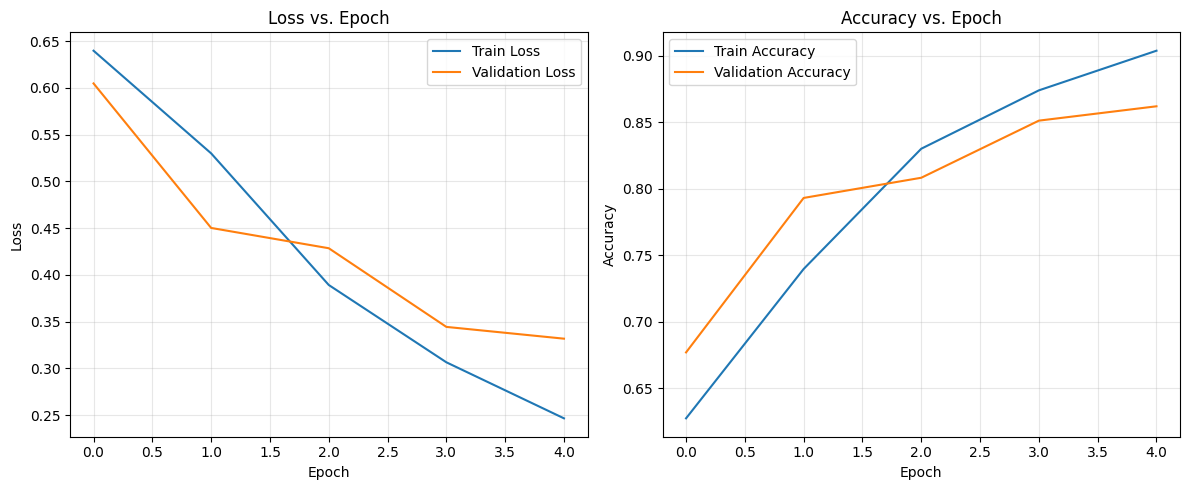

In [52]:
# Plot loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_progress.png')
plt.show()

## 5.2 Making Predictions with New Text

Let's create a function to make predictions on new text:

In [53]:
def predict_sentiment(model, text, tokenizer, device):
    # Clean the text
    cleaned_text = clean_text(text)
    
    # Tokenize
    inputs = tokenizer(
        cleaned_text,
        max_length=MAX_SEQ_LEN,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    # Move to device
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        prediction = torch.sigmoid(model(input_ids, attention_mask).squeeze(1))
    
    # Return prediction as probability
    return prediction.item()

Test with positive examples

In [54]:
positive_examples = [
    "This movie was absolutely fantastic! The acting was superb and the storyline was engaging throughout.",
    "One of the best films I've seen in years. Every scene was perfect.",
    "I laughed, I cried, and I was thoroughly entertained. A masterpiece!",
    "I absolutely lovely hated the movie."
]

print("=== Positive Examples ===")
for example in positive_examples:
    score = predict_sentiment(model, example, tokenizer, device)
    print(f"Text: {example[:50]}...")
    print(f"Sentiment score: {score:.4f}")
    print(f"Prediction: {'Positive' if score > 0.5 else 'Negative'}\n")

=== Positive Examples ===
Text: This movie was absolutely fantastic! The acting wa...
Sentiment score: 0.9886
Prediction: Positive

Text: One of the best films I've seen in years. Every sc...
Sentiment score: 0.9607
Prediction: Positive

Text: I laughed, I cried, and I was thoroughly entertain...
Sentiment score: 0.9457
Prediction: Positive

Text: I absolutely lovely hated the movie....
Sentiment score: 0.6993
Prediction: Positive



Test with negative examples

In [55]:
negative_examples = [
    "What a terrible waste of time. The plot made no sense and the acting was wooden and unconvincing.",
    "I've never been so bored in my life. The characters were flat and the dialogue was cringe-worthy.",
    "Awful directing, terrible screenplay, and lackluster performances throughout. Avoid at all costs."
]

print("=== Negative Examples ===")
for example in negative_examples:
    score = predict_sentiment(model, example, tokenizer, device)
    print(f"Text: {example[:50]}...")
    print(f"Sentiment score: {score:.4f}")
    print(f"Prediction: {'Positive' if score > 0.5 else 'Negative'}\n")

=== Negative Examples ===
Text: What a terrible waste of time. The plot made no se...
Sentiment score: 0.0077
Prediction: Negative

Text: I've never been so bored in my life. The character...
Sentiment score: 0.2329
Prediction: Negative

Text: Awful directing, terrible screenplay, and lacklust...
Sentiment score: 0.0115
Prediction: Negative



Test with ambiguous examples

In [56]:
ambiguous_examples = [
    "The movie had some good moments but also some flaws. The cinematography was impressive.",
    "Not as good as the original, but still worth watching for fans of the series.",
    "The first half was slow, but it picked up in the second half."
]

print("=== Ambiguous Examples ===")
for example in ambiguous_examples:
    score = predict_sentiment(model, example, tokenizer, device)
    print(f"Text: {example[:50]} ...")
    print(f"Sentiment score: {score:.4f}")
    print(f"Prediction: {'Positive' if score > 0.5 else 'Negative'}\n")

=== Ambiguous Examples ===
Text: The movie had some good moments but also some flaw ...
Sentiment score: 0.6518
Prediction: Positive

Text: Not as good as the original, but still worth watch ...
Sentiment score: 0.7922
Prediction: Positive

Text: The first half was slow, but it picked up in the s ...
Sentiment score: 0.1970
Prediction: Negative



<center> --- End of Lab08 --- </center>